In [5]:
# Step 0: Load the new dataset robustly (auto-detect delimiter), quick health check,
# and prepare it for the CLASE-classification pipeline using preprocessing_pipeline.py

import pandas as pd
import io, csv, chardet, os, numpy as np

path = "/content/sample_data/DATASET_2.csv"

# Detect encoding
with open(path, "rb") as f:
    raw = f.read(100_000)
enc = chardet.detect(raw)["encoding"] or "utf-8"

# Peek first lines as text to guess delimiter
sample = raw[:4000].decode(enc, errors="replace")
# naive delimiter guess
delims = [",",";","|","\t"]
counts = {d: sample.count(d) for d in delims}
best_delim = max(counts, key=counts.get)

# Try to read with detected delimiter; fallback to python engine for safety
try:
    df = pd.read_csv(path, sep=best_delim, encoding=enc, engine="python")
except Exception:
    # Fallback: try common delimiters
    for d in [",",";","|","\t"]:
        try:
            df = pd.read_csv(path, sep=d, encoding=enc, engine="python")
            best_delim = d
            break
        except Exception:
            df = None
    if df is None:
        raise

shape = df.shape
cols = df.columns.tolist()

# Basic sanity: trim string columns
for c in df.select_dtypes(include=["object"]).columns:
    df[c] = df[c].astype(str).str.strip().replace({"": np.nan, "nan": np.nan, "NaN": np.nan, "None": np.nan})

summary = {
    "encoding": enc,
    "guessed_delimiter": repr(best_delim),
    "shape": shape,
    "n_cols": len(cols),
    "columns_sample": cols[:12],
    "missing_by_col_top10": df.isna().mean().sort_values(ascending=False).head(10).to_dict()
}

summary


{'encoding': 'utf-8',
 'guessed_delimiter': "';'",
 'shape': (27, 30),
 'n_cols': 30,
 'columns_sample': ['FECHA_DOCUMENTO',
  'DIRECCION',
  'MODELO_HOMOLOGADO_ANT',
  'SUBSIDIO',
  'AÑO',
  'SUBTOTAL',
  'CLASE',
  'TOTAL',
  'CILINDRAJE',
  'MODELO',
  'MODELO_REGISTRADO_SRI',
  'RAMV_CPN'],
 'missing_by_col_top10': {'MODELO_REGISTRADO_SRI': 0.8888888888888888,
  'MODELO_HOMOLOGADO_ANT': 0.8518518518518519,
  'EJES': 0.8518518518518519,
  'RUEDAS': 0.8148148148148148,
  'CAPACIDAD': 0.7037037037037037,
  'RAMV_CPN': 0.7037037037037037,
  'PAIS_ORIGEN': 0.7037037037037037,
  'TONELAJE': 0.6666666666666666,
  'CILINDRAJE': 0.6666666666666666,
  'CLASE': 0.6296296296296297}}

In [6]:
# Prepare target 'CLASE' for classification and do a robust stratified split
import numpy as np
from collections import Counter

df0 = df.copy()
y_col = "CLASE"

# Clean target
df0[y_col] = df0[y_col].astype(str).str.strip()
df0.loc[df0[y_col].isin(["", "nan", "NaN", "None", "NULL"]), y_col] = np.nan

df_sup = df0.dropna(subset=[y_col]).copy()
class_counts = df_sup[y_col].value_counts().to_dict()

class_counts

{'CAMION': 3, 'CAMIONETA': 3, 'AUTOMOVIL': 3, 'JEEP': 1}

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import RandomOverSampler

# 1) Cargar dataset (ajusta sep/encoding según tu archivo grande)
df = pd.read_csv("/content/sample_data/DATASET_2.csv", sep=";", engine="python", encoding="utf-8")

# 2) Objetivo
y_col = "CLASE"

# Limpiar strings y target
for c in df.select_dtypes(include=["object"]).columns:
    df[c] = df[c].astype(str).str.strip().replace({"": np.nan, "nan": np.nan, "NaN": np.nan, "None": np.nan, "NULL": np.nan})

df_sup = df.dropna(subset=[y_col]).copy()

# 3) Split 2 vías con manejo de clases raras (≥2 para estratificar)
vc = df_sup[y_col].value_counts()
rare = vc[vc < 2].index.tolist()
df_rare = df_sup[df_sup[y_col].isin(rare)].copy()          # van entero al train
df_main = df_sup[~df_sup[y_col].isin(rare)].copy()

# Si se puede, estratifica en el split de df_main
if len(df_main) >= 2 * df_main[y_col].nunique():
    # asegurar al menos 1 por clase en test
    test_frac = max(0.2, df_main[y_col].nunique() / len(df_main) + 1e-9)
    Xtr_main, Xte_main = train_test_split(
        df_main, test_size=test_frac, random_state=42, stratify=df_main[y_col]
    )
else:
    Xtr_main, Xte_main = train_test_split(df_main, test_size=0.2, random_state=42, stratify=None)

# Entrenamiento: todo lo de train_main + clases raras
train_df = pd.concat([Xtr_main, df_rare], axis=0).sample(frac=1.0, random_state=42).reset_index(drop=True)
test_df  = Xte_main.copy().reset_index(drop=True)

train_X, train_y = train_df.drop(columns=[y_col]), train_df[y_col]
test_X,  test_y  = test_df.drop(columns=[y_col]),  test_df[y_col]

print("Distribución TRAIN:", train_y.value_counts().to_dict())
print("Distribución TEST :", test_y.value_counts().to_dict())

# 4) Pipeline compacto (compatible con tu sklearn)
num_cols = train_X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in train_X.columns if c not in num_cols]

num_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler())
])

cat_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

prep = ColumnTransformer([
    ("num", num_pipe, num_cols),
    ("cat", cat_pipe, cat_cols)
])

pipe = ImbPipeline([
    ("prep", prep),
    ("ros", RandomOverSampler(random_state=42))  # balanceo robusto con pocas muestras
])

# Fit + transform
Xtr, ytr = pipe.fit_resample(train_X, train_y)
Xte = pipe.named_steps["prep"].transform(test_X)

print("Shapes -> Xtr:", Xtr.shape, "Xte:", Xte.shape)
print("Clases balanceadas en TRAIN:", pd.Series(ytr).value_counts().to_dict())


Distribución TRAIN: {'AUTOMOVIL': 2, 'CAMION': 2, 'CAMIONETA': 1, 'JEEP': 1}
Distribución TEST : {'CAMIONETA': 2, 'CAMION': 1, 'AUTOMOVIL': 1}
Shapes -> Xtr: (8, 97) Xte: (4, 97)
Clases balanceadas en TRAIN: {'CAMIONETA': 2, 'AUTOMOVIL': 2, 'JEEP': 2, 'CAMION': 2}


/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['SUBSIDIO']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['SUBSIDIO']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


Distribución TRAIN: {'AUTOMOVIL': 2, 'CAMION': 2, 'CAMIONETA': 1, 'JEEP': 1}
Distribución TEST : {'CAMIONETA': 2, 'CAMION': 1, 'AUTOMOVIL': 1}
Accuracy: 0.75
F1 macro: 0.7777777777777777

Reporte:
               precision    recall  f1-score   support

   AUTOMOVIL       1.00      1.00      1.00         1
      CAMION       0.50      1.00      0.67         1
   CAMIONETA       1.00      0.50      0.67         2

    accuracy                           0.75         4
   macro avg       0.83      0.83      0.78         4
weighted avg       0.88      0.75      0.75         4



/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['SUBSIDIO']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['SUBSIDIO']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


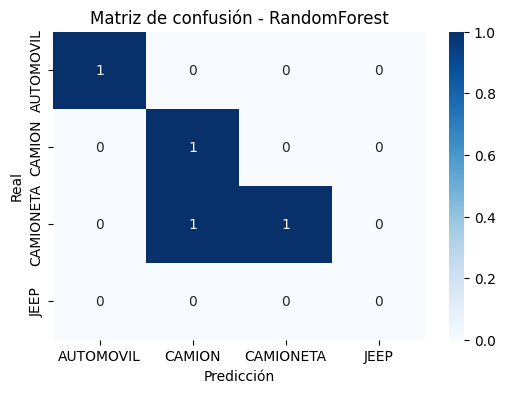

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Cargar dataset
df = pd.read_csv("/content/sample_data/DATASET_2.csv", sep=";", engine="python", encoding="utf-8")
y_col = "CLASE"

# 2) Limpiar strings y target
for c in df.select_dtypes(include=["object"]).columns:
    df[c] = df[c].astype(str).str.strip().replace(
        {"": np.nan, "nan": np.nan, "NaN": np.nan, "None": np.nan, "NULL": np.nan}
    )

df_sup = df.dropna(subset=[y_col]).copy()

# 3) Manejo de clases raras
vc = df_sup[y_col].value_counts()
rare = vc[vc < 2].index.tolist()
df_rare = df_sup[df_sup[y_col].isin(rare)].copy()
df_main = df_sup[~df_sup[y_col].isin(rare)].copy()

# Split
if len(df_main) >= 2 * df_main[y_col].nunique():
    test_frac = max(0.2, df_main[y_col].nunique() / len(df_main) + 1e-9)
    Xtr_main, Xte_main = train_test_split(
        df_main, test_size=test_frac, random_state=42, stratify=df_main[y_col]
    )
else:
    Xtr_main, Xte_main = train_test_split(df_main, test_size=0.2, random_state=42)

train_df = pd.concat([Xtr_main, df_rare], axis=0).sample(frac=1.0, random_state=42).reset_index(drop=True)
test_df  = Xte_main.copy().reset_index(drop=True)

train_X, train_y = train_df.drop(columns=[y_col]), train_df[y_col]
test_X,  test_y  = test_df.drop(columns=[y_col]),  test_df[y_col]

print("Distribución TRAIN:", train_y.value_counts().to_dict())
print("Distribución TEST :", test_y.value_counts().to_dict())

# 4) Pipeline
num_cols = train_X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in train_X.columns if c not in num_cols]

num_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler())
])

cat_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))  # devuelve sparse
])

prep = ColumnTransformer([
    ("num", num_pipe, num_cols),
    ("cat", cat_pipe, cat_cols)
])

pipe = ImbPipeline([
    ("prep", prep),
    ("ros", RandomOverSampler(random_state=42))
])

# Fit + transform
Xtr, ytr = pipe.fit_resample(train_X, train_y)
Xte = pipe.named_steps["prep"].transform(test_X)

# 5) Modelo
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(Xtr, ytr)
y_pred = clf.predict(Xte)

# 6) Métricas
print("Accuracy:", accuracy_score(test_y, y_pred))
print("F1 macro:", f1_score(test_y, y_pred, average="macro"))
print("\nReporte:\n", classification_report(test_y, y_pred))

# Matriz de confusión
cm = confusion_matrix(test_y, y_pred, labels=clf.classes_)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de confusión - RandomForest")
plt.show()


Distribución TRAIN: {'INCOMPLETA': 12, 'COMPLETA': 9}
Distribución TEST : {'INCOMPLETA': 4, 'COMPLETA': 2}
Shapes -> Xtr: (24, 188) Xte: (6, 188)
Clases balanceadas en TRAIN: {'INCOMPLETA': 12, 'COMPLETA': 12}
Accuracy: 1.0
F1 macro: 1.0

Reporte:
               precision    recall  f1-score   support

    COMPLETA       1.00      1.00      1.00         2
  INCOMPLETA       1.00      1.00      1.00         4

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6



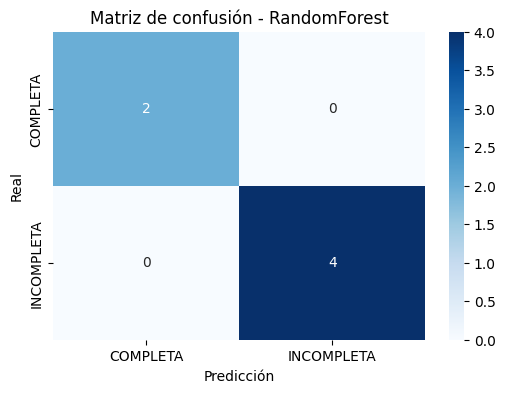


Top 8 variables más importantes:
                                          Variable  Importancia
0                                         num__IVA     0.112658
1                                       num__TOTAL     0.104578
2                                    num__SUBTOTAL     0.102918
3                        cat__RAMV_CPN_B7740044361     0.064632
4                                cat__CLASE_CAMION     0.055094
5                       cat__CILINDRAJE_1.451 C.C.     0.049959
6  cat__CONCESIONARIA_AUTOMOTORES CONTINENTAL S.A.     0.035184
7                cat__VIN_CHASIS_9BG156PK0SC422166     0.032893


In [16]:
import pandas as pd
import numpy as np
import json
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Cargar dataset desde JSON
# The previous attempt to load from JSON caused an error, reverting to CSV
df = pd.read_csv("/content/sample_data/DATASET_2.csv", sep=";", engine="python", encoding="utf-8")

# Variable objetivo
y_col = "ETIQUETA"

# 2) Limpiar strings y target
for c in df.select_dtypes(include=["object"]).columns:
    df[c] = df[c].astype(str).str.strip().replace(
        {"": np.nan, "nan": np.nan, "NaN": np.nan, "None": np.nan, "NULL": np.nan}
    )

df_sup = df.dropna(subset=[y_col]).copy()

# 3) Manejo de clases raras
vc = df_sup[y_col].value_counts()
rare = vc[vc < 2].index.tolist()
df_rare = df_sup[df_sup[y_col].isin(rare)].copy()
df_main = df_sup[~df_sup[y_col].isin(rare)].copy()

# Split estratificado
if len(df_main) > 0: # Ensure df_main is not empty
    if len(df_main) >= 2 * df_main[y_col].nunique() and df_main[y_col].nunique() > 1:
        # Ensure at least 1 sample per class in test and more than one class
        test_frac = max(0.2, df_main[y_col].nunique() / len(df_main))
        Xtr_main, Xte_main = train_test_split(
            df_main, test_size=test_frac, random_state=42, stratify=df_main[y_col]
        )
    else:
        # If stratification is not possible or beneficial, do a simple split
        test_size = 0.5 if len(df_main) > 1 else (1.0 if len(df_main) == 1 else 0.0) # Ensure test set is not empty if possible
        Xtr_main, Xte_main = train_test_split(df_main, test_size=test_size, random_state=42)
else:
    Xtr_main = pd.DataFrame(columns=df_main.columns)
    Xte_main = pd.DataFrame(columns=df_main.columns)


train_df = pd.concat([Xtr_main, df_rare], axis=0).sample(frac=1.0, random_state=42).reset_index(drop=True)
test_df  = Xte_main.copy().reset_index(drop=True)

train_X, train_y = train_df.drop(columns=[y_col]), train_df[y_col]
test_X,  test_y  = test_df.drop(columns=[y_col]),  test_df[y_col]

print("Distribución TRAIN:", train_y.value_counts().to_dict())
print("Distribución TEST :", test_y.value_counts().to_dict())

# 4) Pipeline de preprocesamiento
num_cols = train_X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in train_X.columns if c not in num_cols]

num_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler())
])

cat_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

prep = ColumnTransformer([
    ("num", num_pipe, num_cols),
    ("cat", cat_pipe, cat_cols)
])

pipe = ImbPipeline([
    ("prep", prep),
    ("ros", RandomOverSampler(random_state=42))
])

# Fit + transform
Xtr, ytr = pipe.fit_resample(train_X, train_y)
Xte = pipe.named_steps["prep"].transform(test_X)

print("Shapes -> Xtr:", Xtr.shape, "Xte:", Xte.shape)
print("Clases balanceadas en TRAIN:", pd.Series(ytr).value_counts().to_dict())

# 5) Modelo RandomForest
clf = RandomForestClassifier(n_estimators=200, random_state=42)
clf.fit(Xtr, ytr)
y_pred = clf.predict(Xte)

# 6) Métricas
print("Accuracy:", accuracy_score(test_y, y_pred))
print("F1 macro:", f1_score(test_y, y_pred, average="macro"))
print("\nReporte:\n", classification_report(test_y, y_pred))

# Matriz de confusión
cm = confusion_matrix(test_y, y_pred, labels=clf.classes_)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de confusión - RandomForest")
plt.show()

# 7) Importancia de variables
# Recuperar nombres después de OneHotEncoder
# Get feature names from the preprocessor after fitting
feature_names = pipe.named_steps['prep'].get_feature_names_out()

importances = clf.feature_importances_
feat_imp = pd.DataFrame({"Variable": feature_names, "Importancia": importances})
feat_imp = feat_imp.sort_values("Importancia", ascending=False).reset_index(drop=True)

print("\nTop 8 variables más importantes:")
print(feat_imp.head(8))